**Deep Learning**

In this section, deep learning is implemented using the popular **fastai** library built on top of PyTorch, which is designed to make deep learning accessible and easy to use.
For more information, check [Fastai Documentation](https://docs.fast.ai/)

Code below imports the fastai library and prints the installed version. Knowing the version helps ensure compatibility and access to the latest features.

In [4]:
import fastai
print(fastai.__version__)

2.7.15


Then we import the necessary modules from the fastai library for handling tabular data, as well as the pandas library for data manipulation and Path for file path handling.

In [5]:
from fastai.tabular.all import *
import pandas as pd
from pathlib import Path

This code reads the training and testing datasets from CSV files into Pandas DataFrames for further processing.

In [6]:
train_df = pd.read_csv('/content/multi_class_train_dataset.csv')
test_df = pd.read_csv('/content/multi_class_test_dataset.csv')

This code identifies which columns are categorical and which are continuous. Categorical columns are explicitly listed, while continuous columns are determined by excluding certain columns from the dataset. It then prints out these columns for verification.

In [7]:
# Identify categorical and continuous columns
exclude_columns = ['ID_1', 'APOE4', 'Sex', 'Diagnosis']
cont_names = [col for col in train_df.columns if col not in exclude_columns]
cat_names = ['ID_1', 'APOE4', 'Sex']

# Verify the identified columns
print("Categorical columns:", cat_names)
print("Continuous columns:", cont_names)

Categorical columns: ['ID_1', 'APOE4', 'Sex']
Continuous columns: ['MIMAT0000062', 'MIMAT0000063', 'MIMAT0000064', 'MIMAT0000065', 'MIMAT0000066', 'MIMAT0000067', 'MIMAT0000068', 'MIMAT0000069', 'MIMAT0000070', 'MIMAT0000071', 'MIMAT0000072', 'MIMAT0000073', 'MIMAT0000074', 'MIMAT0000075', 'MIMAT0000076', 'MIMAT0000077', 'MIMAT0000078', 'MIMAT0000079', 'MIMAT0000080', 'MIMAT0000081', 'MIMAT0000082', 'MIMAT0000083', 'MIMAT0000084', 'MIMAT0000085', 'MIMAT0000086', 'MIMAT0000087', 'MIMAT0000088', 'MIMAT0000089', 'MIMAT0000090', 'MIMAT0000091', 'MIMAT0000092', 'MIMAT0000093', 'MIMAT0000094', 'MIMAT0000095', 'MIMAT0000096', 'MIMAT0000097', 'MIMAT0000098', 'MIMAT0000099', 'MIMAT0000100', 'MIMAT0000101', 'MIMAT0000102', 'MIMAT0000103', 'MIMAT0000104', 'MIMAT0000222', 'MIMAT0000226', 'MIMAT0000227', 'MIMAT0000228', 'MIMAT0000231', 'MIMAT0000232, MIMAT0004563', 'MIMAT0000241', 'MIMAT0000242', 'MIMAT0000243', 'MIMAT0000244', 'MIMAT0000245', 'MIMAT0000250', 'MIMAT0000251', 'MIMAT0000252', 'MIMAT0

This code checks for missing values in the training DataFrame, prints the count of missing values for each column and handles missing values by filling them with the mode (most frequent value) for categorical columns and the median for numerical columns. This ensures there are no missing values in the dataset before training the model.

In [8]:
# Check for missing values
print(train_df.isnull().sum())

# Handle missing values by filling them
# This step may already be handled by `FillMissing` in fastai's processing
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        if train_df[col].dtype == 'object':  # For categorical columns
            train_df[col].fillna(train_df[col].mode()[0], inplace=True)
        else:  # For numerical columns
            train_df[col].fillna(train_df[col].median(), inplace=True)

ID_1            0
MIMAT0000062    0
MIMAT0000063    0
MIMAT0000064    0
MIMAT0000065    0
               ..
MIMAT0035704    0
Diagnosis       0
Age             0
Sex             0
APOE4           0
Length: 2567, dtype: int64


**Preprocessing Steps:**

* `procs` defines the preprocessing steps:
  * `Categorify` takes every categorical variable and makes a map from integer to unique categories, then replaces the values by the corresponding index.
  * `FillMissing` will fill the missing values in the continuous variables by the median of existing values
  * `Normalize` will normalize the continuous variables (subtract the mean and divide by the std)

**Splitting and Data Loading:**

* `splits` defines how the data is split into training and validation sets:
  * `RandomSplitter` splits the data with a specified validation percentage (Usually 80/20).

* `TabularDataLoaders` creates data loaders from the DataFrame:
  * It uses the specified preprocessing steps, categorical and continuous column names, target variable (`Diagnosis`), batch size (`bs`), and data splits.


In [9]:
from fastai.tabular.all import *

# Define preprocessing steps
procs = [Categorify, FillMissing, Normalize]

splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

# Create TabularDataLoaders
dls_train = TabularDataLoaders.from_df(train_df,
                                       procs=procs,
                                       cat_names=cat_names,
                                       cont_names=cont_names,
                                       y_names='Diagnosis',
                                       y_block=CategoryBlock(),
                                       bs=256,
                                       splits = splits,
                                       index_col = 'ID_1')

# Verify the DataLoader
dls_train.show_batch()

**Model Definition:**

* `tabular_learner` creates a neural network model with:
  * Three hidden layers, each containing 200 neurons.
  * Accuracy as the evaluation metric.

In [10]:
layers = [200, 200, 200, 200, 200, 200]
learn = tabular_learner(dls_train, layers=layers, metrics=accuracy)

**Finding the Optimal Learning Rate:**

* `learn.lr_find` runs a learning rate finder to identify the optimal learning rate.
* `plot_lr_find` plots the learning rate curve.

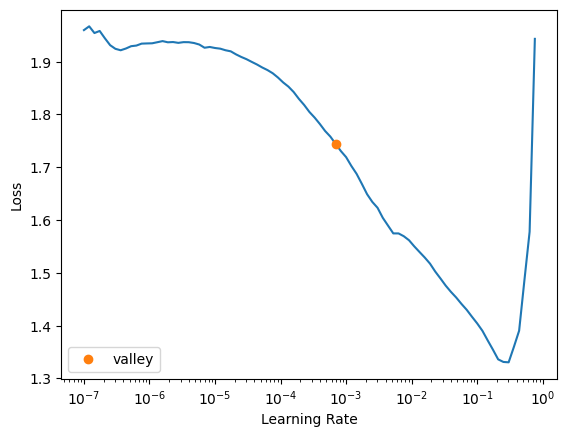

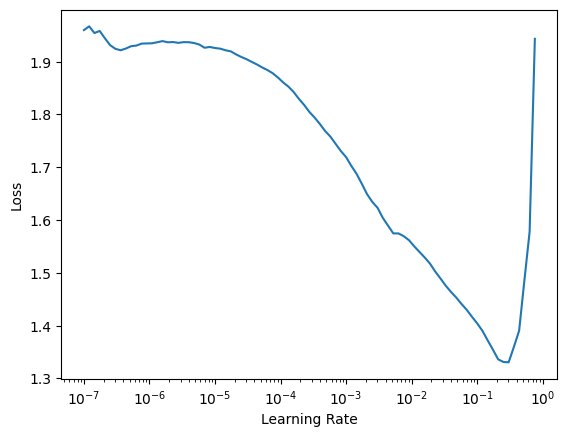

In [11]:
# Find the optimal learning rate
learn.lr_find()
learn.recorder.plot_lr_find()

**Training the Model:**

* `learn.fit_one_cycle(8, optimal_lr)` trains the model for 8 epochs using the optimal learning rate found earlier.

In [12]:
optimal_lr = 1e-3

# Train the model
learn.fit_one_cycle(1000, optimal_lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.898161,1.761249,0.048327,00:00
1,1.835236,1.745199,0.048327,00:00
2,1.778110,1.725401,0.052045,00:00
3,1.738894,1.703505,0.226766,00:00
4,1.694379,1.680343,0.334572,00:00
5,1.657745,1.675080,0.353160,00:00
6,1.626217,1.682959,0.353160,00:00
7,1.594583,1.703842,0.330855,00:00
8,1.563645,1.729172,0.289963,00:00
9,1.532201,1.753938,0.275093,00:00


Code below ensures that the test dataset is preprocessed in the same way as the training dataset. Specifically, it handles missing values in the test dataset using the same strategy applied to the training data. This step is crucial for maintaining consistency in preprocessing, which ensures that the model is evaluated fairly and accurately.

- **Categorical columns**: Missing values are filled with the most frequent value (mode) of that column.
- **Numerical columns**: Missing values are filled with the median value of that column.

In [13]:
# Ensure the test dataset is preprocessed similarly
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        if test_df[col].dtype == 'object':
            test_df[col].fillna(test_df[col].mode()[0], inplace=True)
        else:
            test_df[col].fillna(test_df[col].median(), inplace=True)

Code below evaluates the performance of the trained model on the test dataset. The evaluation process involves generating predictions from the model, comparing these predictions to the true labels, and calculating the accuracy of the model.

1. **Creating Test Data Loaders**: `dls_test` is created using `dls_train.test_dl(test_df)`, which prepares the test dataset for model evaluation using the same preprocessing and batch settings as the training dataset.
2. **Getting Predictions and Targets**: `learn.get_preds(dl=dls_test)` retrieves the model’s predictions and the true labels from the test data loader.
3. **Converting Predictions**: `preds.argmax(dim=1)` converts the model’s output probabilities into class labels.
4. **Calculating Accuracy**: `accuracy_score(targets, pred_labels)` computes the accuracy of the model by comparing the predicted labels to the true labels. The accuracy score is then printed to show how well the model performs on the test dataset.


In [14]:
from sklearn.metrics import accuracy_score

# Create test TabularDataLoaders
dls_test = dls_train.test_dl(test_df)

# Get predictions and targets
preds, targets = learn.get_preds(dl=dls_test)

# Convert predictions to class labels
pred_labels = preds.argmax(dim=1)

# Calculate accuracy
test_accuracy = accuracy_score(targets, pred_labels)
print(f'Test Set Accuracy: {test_accuracy:.4f}')

Test Set Accuracy: 0.6766


**Save the results**

Code below saves a trained model to disk and then reload it for future use or evaluation. This is useful for preserving the model after training so it can be reused without needing to retrain it from scratch.

In this code:
1. **Saving the Model**: `learn.export('ad_vs_nc_saved_model.pkl')` saves the trained model to a file named `'ad_vs_nc_saved_model.pkl'`. This file contains the model’s architecture, parameters, and training state.
2. **Loading the Model**: `learn = load_learner('ad_vs_nc_saved_model.pkl')` reloads the saved model from the file. This allows you to use the model for predictions or further evaluation without having to retrain it.
3. **Inspecting Model Parameters**: `param_names = list(learn.model.parameters())` retrieves the parameters of the model to inspect or analyze them. `print(param_names)` prints these parameters, which helps in understanding or debugging the model.


In [ ]:
learn.export('ad_vs_nc_saved_model.pkl')

In [ ]:
learn = load_learner('ad_vs_nc_saved_model.pkl')

In [ ]:
param_names = list(learn.model.parameters())
print(param_names)

[Parameter containing:
tensor([[-0.0110, -0.0077,  0.0184,  ..., -0.0014, -0.0033, -0.0037],
        [ 0.0170, -0.0250, -0.0370,  ..., -0.0035,  0.0260, -0.0067],
        [ 0.0215, -0.0231, -0.0066,  ..., -0.0192,  0.0176, -0.0342],
        ...,
        [-0.1203,  0.1181,  0.1076,  ...,  0.1054, -0.1475,  0.1279],
        [-0.0805,  0.1175,  0.1225,  ...,  0.1303, -0.1028,  0.0812],
        [-0.0813,  0.0773,  0.0827,  ...,  0.0712, -0.0549,  0.0543]], requires_grad=True), Parameter containing:
tensor([[ 0.0031,  0.0070, -0.0055],
        [ 0.3118,  0.3376,  0.2750],
        [-0.2955, -0.3310, -0.2454],
        [-0.2644, -0.2850, -0.1924]], requires_grad=True), Parameter containing:
tensor([[ 0.0017, -0.0114, -0.0013],
        [ 0.2827,  0.3148,  0.3546],
        [-0.2990, -0.3160, -0.3415]], requires_grad=True), Parameter containing:
tensor([0.9904, 0.9955, 1.0102,  ..., 0.9548, 0.9829, 1.4893], requires_grad=True), Parameter containing:
tensor([-0.0428, -0.0248,  0.0412,  ..., -0.052